In [11]:
import os
import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import torch
import pandas as pd
import os
import matplotlib.pyplot as plt
from nilearn.plotting import plot_connectome
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from collections import defaultdict
from torch_geometric.loader import DataLoader
import numpy as np


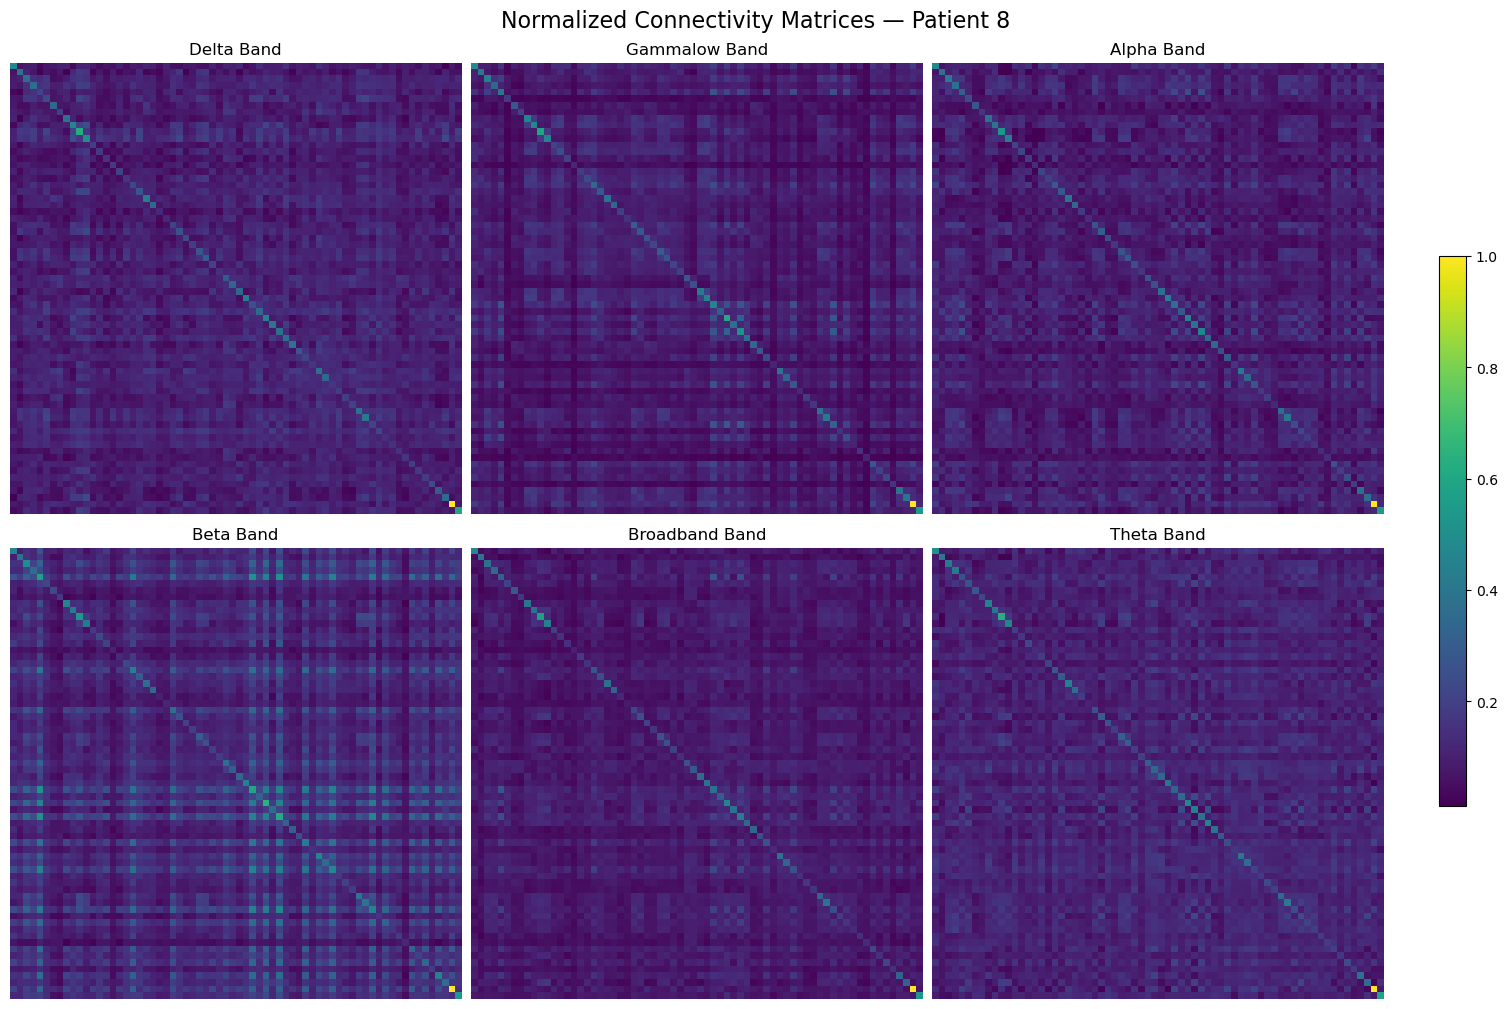

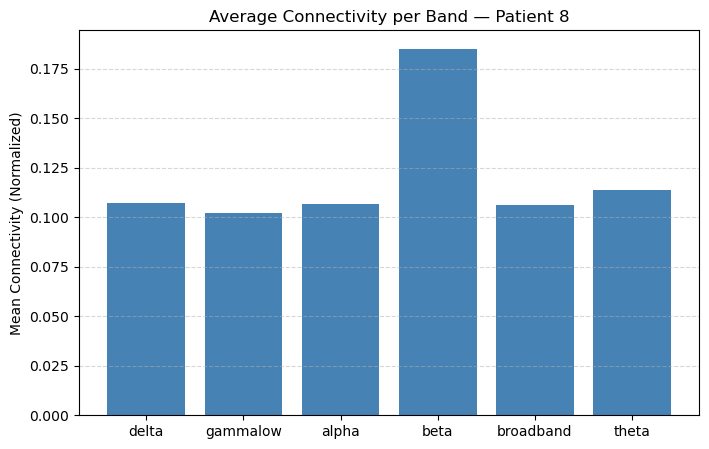

In [9]:
import matplotlib.pyplot as plt

# Set patient ID and bands
patient_id = 8 # pick any valid ID from 8 to 276
frequency_bands = ['delta', 'gammalow', 'alpha', 'beta', 'broadband', 'theta']
num_bands = len(frequency_bands)

# Load the 6 band matrices for this patient
patient_directory = os.path.join(base_directory, f"p{patient_id}")
edge_features_list = []

for band in frequency_bands:
    file_path = os.path.join(patient_directory, f"{band}_connectivity.csv")
    matrix = pd.read_csv(file_path, header=0, index_col=0).values.astype(np.float32)
    tensor = torch.tensor(matrix, dtype=torch.float32)
    max_val = torch.max(tensor)
    normalized_tensor = tensor / max_val if max_val > 0 else tensor
    edge_features_list.append(normalized_tensor)

# Stack into tensor [bands, 68, 68]
combined_edge_features_tensor = torch.stack(edge_features_list)


fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
axs = axs.flatten()
cmap_choice = 'viridis'

for i, band in enumerate(frequency_bands):
    matrix = combined_edge_features_tensor[i].numpy()
    im = axs[i].imshow(matrix, cmap=cmap_choice)
    axs[i].set_title(f"{band.capitalize()} Band")
    axs[i].axis('off')

# Shared colorbar
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.suptitle(f"Normalized Connectivity Matrices — Patient {patient_id}", fontsize=16)
plt.show()

# ---------- Average per Band ----------
avg_per_band = [combined_edge_features_tensor[i].mean().item() for i in range(num_bands)]

plt.figure(figsize=(8, 5))
plt.bar(frequency_bands, avg_per_band, color='steelblue')
plt.ylabel("Mean Connectivity (Normalized)")
plt.title(f"Average Connectivity per Band — Patient {patient_id}")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [10]:
import numpy as np
import os
import torch
import pandas as pd

# Define region labels (68 total, Desikan-Killiany)
region_labels = [
    'BanksSTS-L', 'BanksSTS-R', 'CaudalAnteriorCingulate-L', 'CaudalAnteriorCingulate-R',
    'CaudalMiddleFrontal-L', 'CaudalMiddleFrontal-R', 'Cuneus-L', 'Cuneus-R',
    'Entorhinal-L', 'Entorhinal-R', 'Fusiform-L', 'Fusiform-R',
    'InferiorParietal-L', 'InferiorParietal-R', 'InferiorTemporal-L', 'InferiorTemporal-R',
    'Insula-L', 'Insula-R', 'IsthmusCingulate-L', 'IsthmusCingulate-R',
    'LateralOccipital-L', 'LateralOccipital-R', 'LateralOrbitofrontal-L', 'LateralOrbitofrontal-R',
    'Lingual-L', 'Lingual-R', 'MedialOrbitofrontal-L', 'MedialOrbitofrontal-R',
    'MiddleTemporal-L', 'MiddleTemporal-R', 'Parahippocampal-L', 'Parahippocampal-R',
    'Paracentral-Lobule-L', 'Paracentral-Lobule-R', 'ParsOpercularis-L', 'ParsOpercularis-R',
    'ParsOrbitalis-L', 'ParsOrbitalis-R', 'ParsTriangularis-L', 'ParsTriangularis-R',
    'Pericalcarine-L', 'Pericalcarine-R', 'Postcentral-L', 'Postcentral-R',
    'PosteriorCingulate-L', 'PosteriorCingulate-R', 'Precentral-L', 'Precentral-R',
    'Precuneus-L', 'Precuneus-R', 'RostralAnteriorCingulate-L', 'RostralAnteriorCingulate-R',
    'RostralMiddleFrontal-L', 'RostralMiddleFrontal-R', 'SuperiorFrontal-L', 'SuperiorFrontal-R',
    'SuperiorParietal-L', 'SuperiorParietal-R', 'SuperiorTemporal-L', 'SuperiorTemporal-R',
    'Supramarginal-L', 'Supramarginal-R', 'FrontalPole-L', 'FrontalPole-R',
    'TemporalPole-L', 'TemporalPole-R', 'TransverseTemporal-L', 'TransverseTemporal-R'
]

# Set parameters
base_directory = "/Users/sogandghasemi/Documents/uni/Stage/project/data"
frequency_bands = ['delta', 'gammalow', 'alpha', 'beta', 'broadband', 'theta']
patient_index = 8
band_index = 0  # delta band

# Load connectivity matrix for this patient
patient_directory = os.path.join(base_directory, f"p{patient_index}")
edge_features_list = []

for band in frequency_bands:
    file_path = os.path.join(patient_directory, f"{band}_connectivity.csv")
    matrix = pd.read_csv(file_path, index_col=0).values.astype(np.float32)
    tensor = torch.tensor(matrix)
    max_val = torch.max(tensor)
    normalized_tensor = tensor / max_val if max_val > 0 else tensor
    edge_features_list.append(normalized_tensor)

# Stack into shape [bands, 68, 68]
combined_edge_features_tensor = torch.stack(edge_features_list)

# Extract matrix for selected band
matrix = combined_edge_features_tensor[band_index].numpy()

#if we want to ignore self loops
# (np.fill_diagonal)

# Get upper triangle INCLUDING diagonal (self-loops allowed)
triu_indices = np.triu_indices_from(matrix, k=0)

flattened = matrix[triu_indices]
top5_idx = np.argsort(flattened)[-5:][::-1]
top5_vals = flattened[top5_idx]
top5_coords = list(zip(triu_indices[0][top5_idx], triu_indices[1][top5_idx]))

# Print results with region names and indices
print(f"\n🔝 Top 5 Most Connected Node Pairs (INCLUDING SELF-LOOPS) in {frequency_bands[band_index].upper()} Band (Patient {patient_index})")
for (i, j), val in zip(top5_coords, top5_vals):
    region_i = f"{region_labels[i]} ({i})"
    region_j = f"{region_labels[j]} ({j})"
    print(f"{region_i} ↔ {region_j}: {val:.3f}")



🔝 Top 5 Most Connected Node Pairs (INCLUDING SELF-LOOPS) in DELTA Band (Patient 8)
TransverseTemporal-L (66) ↔ TransverseTemporal-L (66): 1.000
Fusiform-L (10) ↔ Fusiform-L (10): 0.628
TransverseTemporal-R (67) ↔ TransverseTemporal-R (67): 0.597
Fusiform-R (11) ↔ Fusiform-R (11): 0.505
BanksSTS-L (0) ↔ BanksSTS-L (0): 0.476


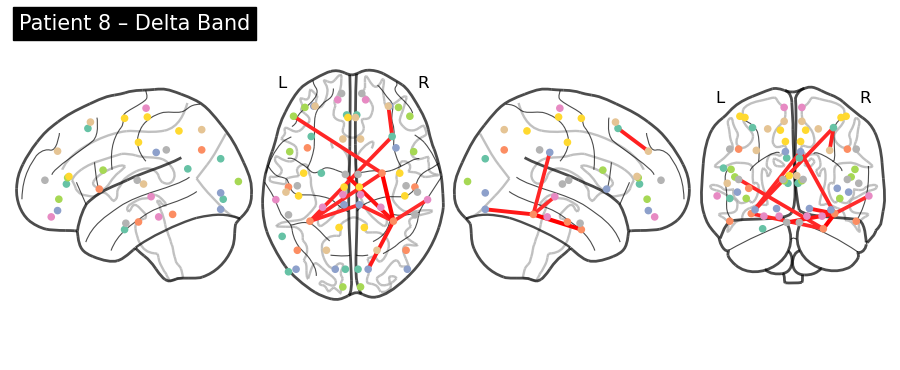

In [18]:
# --- Define 68-region Desikan-Killiany MNI coordinates ---
desikan_killiany_mni_coords = np.array([
    [-55, -57, 19], [-50, -85, -5], [-4, 39, 7], [4, 39, 7], [-32, 22, 51], [32, 22, 51],
    [-5, -83, 27], [5, -83, 27], [-24, -7, -29], [24, -7, -29], [-33, -45, -17], [33, -45, -17],
    [-43, -68, 34], [43, -68, 34], [-50, -18, -23], [50, -18, -23],
    [-35, 13, 3], [35, 13, 3], [-6, -32, 32], [6, -32, 32],
    [-44, -83, 0], [44, -83, 0], [-30, 46, -14], [30, 46, -14],
    [-13, -83, -13], [13, -83, -13], [-11, 51, -19], [11, 51, -19],
    [-60, -28, -3], [60, -28, -3], [-23, -34, -19], [23, -34, -19],
    [-7, -24, 67], [7, -24, 67], [-49, 10, 18], [49, 10, 18],
    [-37, 45, -5], [37, 45, -5], [-46, 38, 12], [46, 38, 12],
    [-7, -97, 9], [7, -97, 9], [-42, -25, 60], [42, -25, 60],
    [-6, -18, 40], [6, -18, 40], [-38, -7, 59], [38, -7, 59],
    [-10, -50, 49], [10, -50, 49], [-3, 37, 13], [3, 37, 13],
    [-29, 46, 33], [29, 46, 33], [-7, 20, 56], [7, 20, 56],
    [-20, -68, 50], [20, -68, 50], [-52, -22, 7], [52, -22, 7],
    [-50, -40, 34], [50, -40, 34], [8, 56, 10], [-8, 56, 10],
    [5, -8, -24], [-5, -8, -24], [-43, -17, 10], [43, -17, 10]
])

# --- Function to plot top-k connections on a glass brain ---
def plot_top_nilearn(matrix, region_coords, top_k=10, title="Top Connectome Edges"):
    # Zero self-connections
    np.fill_diagonal(matrix, 0)

    # Get upper triangle and flatten
    triu_indices = np.triu_indices_from(matrix, k=1)
    flattened = matrix[triu_indices]
    top_idx = np.argsort(flattened)[-top_k:][::-1]
    top_coords = list(zip(triu_indices[0][top_idx], triu_indices[1][top_idx]))

    # Create sparse matrix with only top_k connections
    sparse_conn = np.zeros_like(matrix)
    for i, j in top_coords:
        sparse_conn[i, j] = matrix[i, j]
        sparse_conn[j, i] = matrix[i, j]  # ensure symmetry

    # Plot
    plot_connectome(sparse_conn, node_coords=region_coords,
                    edge_threshold='0%', node_size=20,
                    title=title, display_mode='lzry')

# --- Load and normalize matrix for selected patient ---
base_directory = "/Users/sogandghasemi/Documents/uni/Stage/project/data"
frequency_bands = ['delta', 'gammalow', 'alpha', 'beta', 'broadband', 'theta']
patient_id = 8
band_index = 0  # delta

# Load matrix for this band
patient_dir = os.path.join(base_directory, f"p{patient_id}")
file_path = os.path.join(patient_dir, f"{frequency_bands[band_index]}_connectivity.csv")

matrix = pd.read_csv(file_path, index_col=0).values.astype(np.float32)
tensor = torch.tensor(matrix)
max_val = torch.max(tensor)
normalized_matrix = (tensor / max_val).numpy() if max_val > 0 else tensor.numpy()

# --- Plot on glass brain ---
plot_top_nilearn(normalized_matrix, desikan_killiany_mni_coords, top_k=10,
                 title=f"Patient {patient_id} – {frequency_bands[band_index].capitalize()} Band")



Processing Patient 8...
Loading file: delta band
Loading file: gammalow band
Loading file: alpha band
Loading file: beta band
Loading file: broadband band
Loading file: theta band


/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_1412/725101013.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


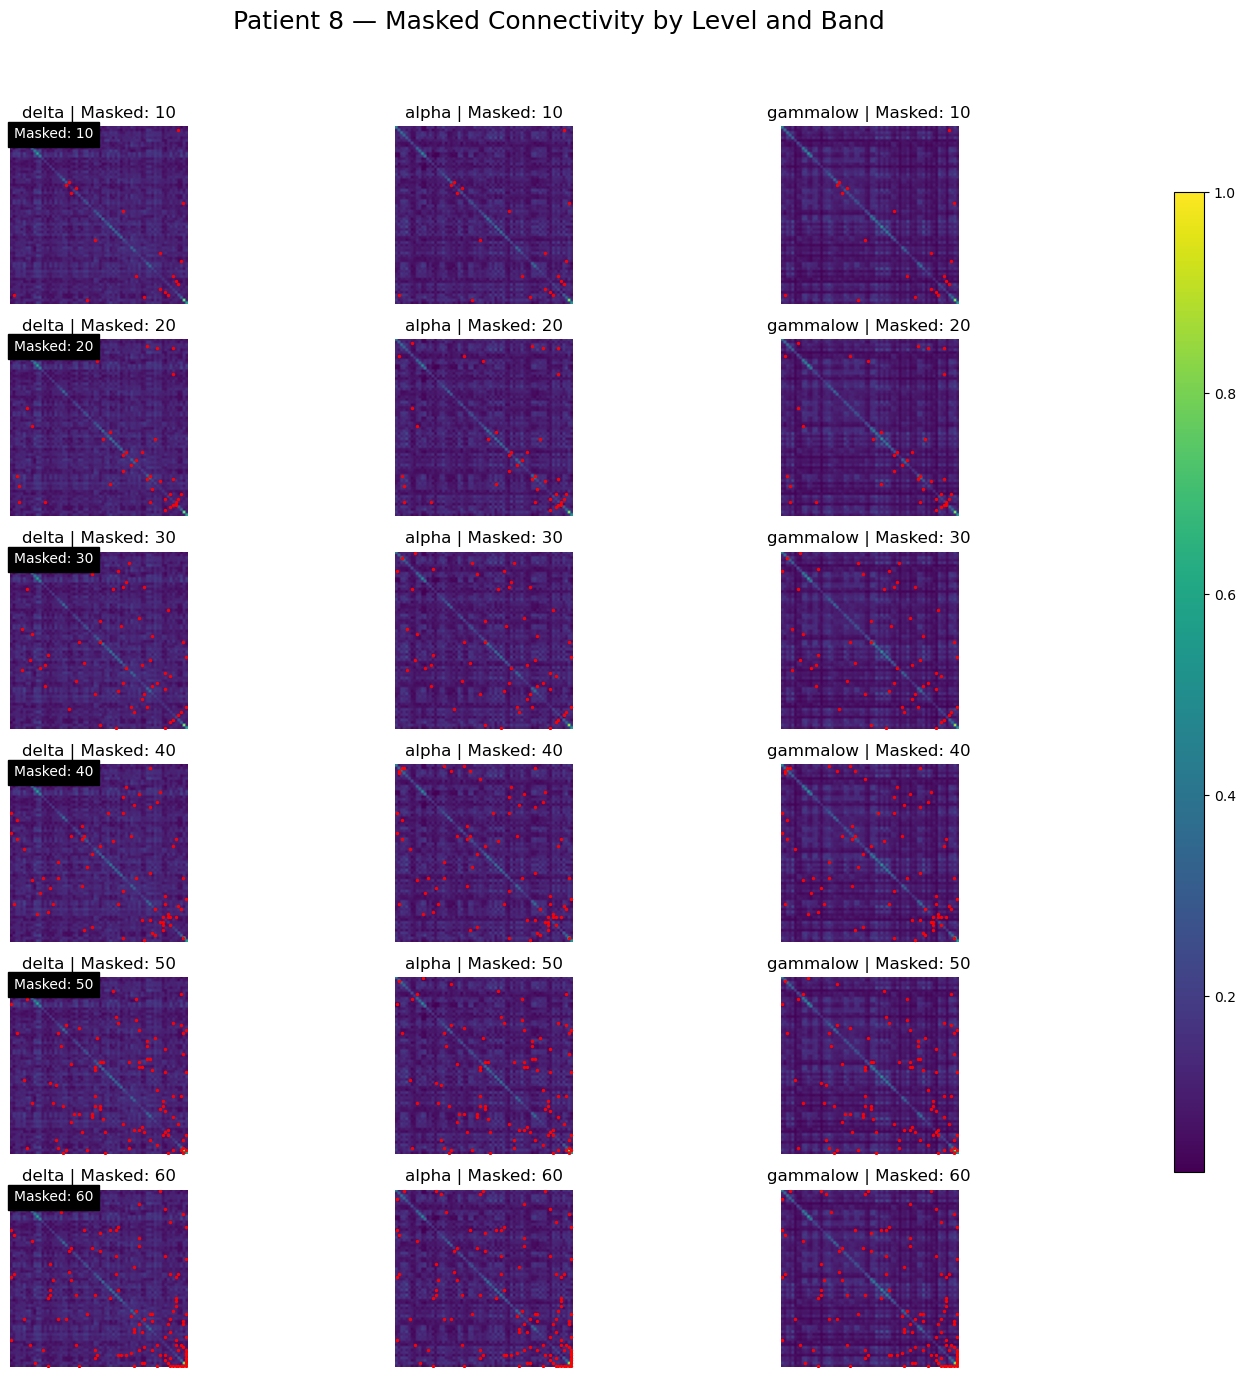

Directory does not exist for patient 9

Processing Patient 10...
Loading file: delta band
Loading file: gammalow band
Loading file: alpha band
Loading file: beta band
Loading file: broadband band
Loading file: theta band
Directory does not exist for patient 11
Directory does not exist for patient 12
Directory does not exist for patient 13
Directory does not exist for patient 14
Directory does not exist for patient 15
Directory does not exist for patient 16

Processing Patient 17...
Loading file: delta band
Loading file: gammalow band
Loading file: alpha band
Loading file: beta band
Loading file: broadband band
Loading file: theta band
Directory does not exist for patient 18
Directory does not exist for patient 19
Directory does not exist for patient 20
Directory does not exist for patient 21
Directory does not exist for patient 22
Directory does not exist for patient 23
Directory does not exist for patient 24

Processing Patient 25...
Loading file: delta band
Loading file: gammalow ban

In [33]:
# Paths and parameters
base_directory = "/Users/sogandghasemi/Documents/uni/Stage/project/data"
frequency_bands = ['delta', 'gammalow', 'alpha', 'beta', 'broadband', 'theta']
masking_levels = [10, 20, 30, 40, 50, 60]
selected_bands = ['delta', 'alpha', 'gammalow']
num_nodes = 68
visualize_patient_id = 8  # which patient to visualize masking

# Function to create a masked graph
def create_masked_graph(conn_matrices, num_nodes=68, num_bands=6, num_edges_to_mask=60):
    edge_index = []
    edge_features = []
    edge_features_masked = []
    mask_indices = []
    mask_matrix = torch.zeros(num_nodes, num_nodes)

    unique_masked_pairs = set()
    while len(unique_masked_pairs) < num_edges_to_mask:
        i = np.random.randint(0, num_nodes)
        j = np.random.randint(i, num_nodes)
        if (i, j) not in unique_masked_pairs:
            unique_masked_pairs.add((i, j))

    for (i, j) in unique_masked_pairs:
        mask_matrix[i, j] = 1
        mask_matrix[j, i] = 1

    edge_counter = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_index.append([i, j])
            edge_feature = conn_matrices[:, i, j]
            edge_features.append(edge_feature)

            if mask_matrix[i, j] == 1:
                mask_indices.append(edge_counter)
                edge_features_masked.append(torch.zeros_like(edge_feature))
            else:
                edge_features_masked.append(edge_feature)

            edge_counter += 1

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_features = torch.stack(edge_features)
    edge_features_masked = torch.stack(edge_features_masked)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    x = torch.ones(num_nodes, 1, dtype=torch.float)

    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_features_masked,
        edge_attr_target=edge_features,
        mask_indices=mask_indices,
        mask_matrix=mask_matrix  # optional, useful for plotting
    )

# Begin dataset creation
graph_list = []

for patient_id in range(8, 277):
    patient_directory = os.path.join(base_directory, f"p{patient_id}")

    if os.path.exists(patient_directory):
        print(f"\nProcessing Patient {patient_id}...")
        edge_features_list = []

        for band in frequency_bands:
            file_path = os.path.join(patient_directory, f"{band}_connectivity.csv")
            if os.path.exists(file_path):
                print(f"Loading file: {band} band")
                matrix = pd.read_csv(file_path, header=0, index_col=0).values.astype(np.float32)
                edge_features_list.append(matrix)
            else:
                print(f"Missing file: {band} for patient {patient_id}")

        if len(edge_features_list) == 6:
            # Normalize each band separately
            normalized_matrices = []
            for matrix in edge_features_list:
                tensor = torch.tensor(matrix, dtype=torch.float32)
                max_val = torch.max(tensor)
                normalized = tensor / max_val if max_val > 0 else tensor
                normalized_matrices.append(normalized)

            conn_matrices = torch.stack(normalized_matrices)  # shape: [6, 68, 68]

            # For visualization (only once for one patient)
            if patient_id == visualize_patient_id:
                fig, axs = plt.subplots(len(masking_levels), len(selected_bands), figsize=(15, 14))
                axs = np.array(axs)

            for row, num_masked in enumerate(masking_levels):
                graph = create_masked_graph(conn_matrices, num_nodes=num_nodes, num_edges_to_mask=num_masked)
                
                graph.patient_id = patient_id  
                graph_list.append(graph)

                if patient_id == visualize_patient_id:
                    edge_index = graph.edge_index.numpy()
                    mask_indices = graph.mask_indices.numpy()
                    edge_list = edge_index.T

                    # Build mask matrix
                    mask_matrix = np.zeros((num_nodes, num_nodes))
                    for idx in mask_indices:
                        i, j = edge_list[idx]
                        mask_matrix[i, j] = 1

                    for col, band_name in enumerate(selected_bands):
                        band_idx = frequency_bands.index(band_name)
                        matrix = conn_matrices[band_idx].numpy()

                        ax = axs[row, col]
                        im = ax.imshow(matrix, cmap='viridis')
                        ax.set_title(f"{band_name} | Masked: {num_masked}")
                        ax.axis('off')

                        masked_coords = np.argwhere(mask_matrix == 1)
                        for (i, j) in masked_coords:
                            ax.scatter(j, i, color='red', s=2)

                        if col == 0:
                            ax.text(1, 4, f"Masked: {num_masked}", color='white', fontsize=10, backgroundcolor='black')

            if patient_id == visualize_patient_id:
                fig.subplots_adjust(right=0.88)
                cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
                fig.colorbar(im, cax=cbar_ax)
                plt.suptitle(f"Patient {patient_id} — Masked Connectivity by Level and Band", fontsize=18)
                plt.tight_layout(rect=[0, 0, 0.9, 0.95])
                plt.show()

        else:
            print(f"Skipping patient {patient_id}: missing one or more bands.")
    else:
        print(f"Directory does not exist for patient {patient_id}")

# Final graph dataset
graph_data = graph_list
print(f"\nTotal graphs created: {len(graph_data)}")


In [21]:
from torch.utils.data import Dataset

class NoisyGraphDataset(Dataset):
    def __init__(self, graph_list, noise_std=0.01, add_noise=True):
        self.graphs = graph_list
        self.noise_std = noise_std
        self.add_noise = add_noise

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        graph = self.graphs[idx].clone()  # clone to avoid modifying original

        if self.add_noise:
            noise = torch.randn_like(graph.edge_attr) * self.noise_std
            graph.edge_attr += noise  # Only perturb the masked graph features

        return graph


In [22]:
graph_data = graph_list 
print(f"Total graphs (patients): {len(graph_data)}")
print("Sample graph structure:")
print(f"  - Nodes: {graph_data[0].num_nodes}")
print(f"  - Edges: {graph_data[0].num_edges}")
print(f"  - Masked edges: {len(graph_data[0].mask_indices)}")


Total graphs (patients): 426
Sample graph structure:
  - Nodes: 68
  - Edges: 4624
  - Masked edges: 17


In [35]:
# Group graphs by patient_id
graphs_by_patient = defaultdict(list)
for g in graph_data:
    pid = g.patient_id  # Make sure this attribute exists on each graph!
    graphs_by_patient[pid].append(g)

# Split patients
all_patient_ids = list(graphs_by_patient.keys())
np.random.seed(42)
shuffled = np.random.permutation(all_patient_ids)
n_total = len(shuffled)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

train_ids = shuffled[:n_train]
val_ids = shuffled[n_train:n_train + n_val]
test_ids = shuffled[n_train + n_val:]

# Assign graphs to sets
train_graphs = [g for pid in train_ids for g in graphs_by_patient[pid]]
val_graphs = [g for pid in val_ids for g in graphs_by_patient[pid]]
test_graphs = [g for pid in test_ids for g in graphs_by_patient[pid]]

# Wrap into Datasets
train_dataset = NoisyGraphDataset(train_graphs, noise_std=0.01, add_noise=True)
val_dataset = NoisyGraphDataset(val_graphs, noise_std=0.01, add_noise=False)
test_dataset = NoisyGraphDataset(test_graphs, noise_std=0.01, add_noise=False)

# Loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


EdgeConv Layer: A custom layer that performs edge convolutions, aggregating information from neighboring nodes.

Message: Concatenates the features gives it to sequential

In [24]:
class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(EdgeConv, self).__init__(aggr='mean')  # also 'add' or 'max'
        self.mlp = nn.Sequential(
            nn.Linear(2 * in_channels + in_channels, out_channels), #2 input channels: for both in_channels(two nodes)
                                                                    #1 in_channels for edge features
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(out_channels, out_channels)
        )
    
    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):   #x_i source node, x_j target node
        tmp = torch.cat([x_i, x_j, edge_attr], dim=1)   #concatenate features of source node, target node and the edge: 2 * in_channels + in_channels
        return self.mlp(tmp)


In [25]:
class EGNNEdgePredictor(nn.Module):
    def __init__(self, node_dim=1, edge_dim=6, hidden_dim=32):
        super(EGNNEdgePredictor, self).__init__()

        self.node_encoder = nn.Sequential(
            nn.Linear(node_dim, hidden_dim),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, hidden_dim),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.conv1 = EdgeConv(hidden_dim, hidden_dim)
        self.conv2 = EdgeConv(hidden_dim, hidden_dim)
        

        self.edge_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2 + hidden_dim, hidden_dim),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden_dim, edge_dim)
        )

    def forward(self, x, edge_index, edge_attr):
        x = self.node_encoder(x)
        edge_features = self.edge_encoder(edge_attr)

        x = self.conv1(x, edge_index, edge_features)
        x = self.conv2(x, edge_index, edge_features)

        src, dst = edge_index   #getting the index of connected nodes
        src_features = x[src]   #updated features of source node
        dst_features = x[dst]   #updated features of target node

        edge_pred_input = torch.cat([src_features, dst_features, edge_features], dim=1)  #all of the features have 32 dim: 32*3
        predicted_edge_features = self.edge_predictor(edge_pred_input)  #edge feature prediction
        return predicted_edge_features


In [26]:
def weighted_mse_loss(pred, target):
    weights = torch.ones_like(target)
    return F.mse_loss(pred, target, reduction='mean')

Using device: cpu
Starting training...
Epoch 1: Train Loss = 0.027666, Val Loss = 0.033555
Saved best model at epoch 1 (val loss: 0.033555)
Saved best model at epoch 2 (val loss: 0.021085)
Saved best model at epoch 3 (val loss: 0.018177)
Saved best model at epoch 4 (val loss: 0.014674)
Saved best model at epoch 5 (val loss: 0.012443)
Saved best model at epoch 6 (val loss: 0.012103)
Saved best model at epoch 8 (val loss: 0.011197)
Saved best model at epoch 9 (val loss: 0.011100)
Epoch 10: Train Loss = 0.006563, Val Loss = 0.008640
Saved best model at epoch 10 (val loss: 0.008640)
Saved best model at epoch 11 (val loss: 0.008277)
Saved best model at epoch 14 (val loss: 0.007498)
Saved best model at epoch 15 (val loss: 0.006429)
Saved best model at epoch 17 (val loss: 0.006392)
Saved best model at epoch 18 (val loss: 0.005939)
Epoch 20: Train Loss = 0.004799, Val Loss = 0.005372
Saved best model at epoch 20 (val loss: 0.005372)
Saved best model at epoch 22 (val loss: 0.005252)
Saved best 

/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_1412/4024587307.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_egnn_m

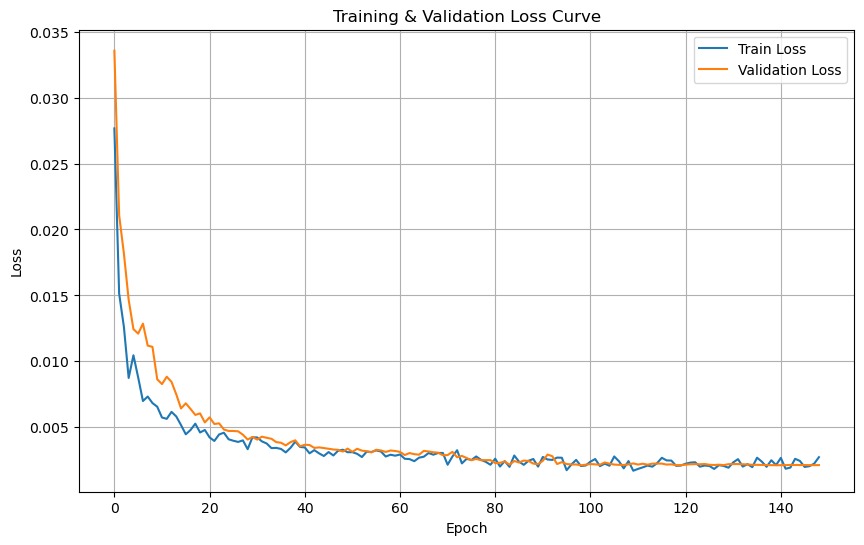

In [48]:

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize model, optimizer, scheduler, and loss function
model = EGNNEdgePredictor(node_dim=1, edge_dim=6, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
criterion = weighted_mse_loss

num_epochs = 300
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_epoch = 0
early_stopping_patience = 50
patience_counter = 0

print("Starting training...")

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0

    for graph in train_loader:
        graph = graph.to(device)
        optimizer.zero_grad()
        pred = model(graph.x, graph.edge_index, graph.edge_attr)

        if graph.mask_indices.numel() > 0:
            loss = criterion(pred[graph.mask_indices], graph.edge_attr_target[graph.mask_indices])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for graph in val_loader:
            graph = graph.to(device)
            pred = model(graph.x, graph.edge_index, graph.edge_attr)

            if graph.mask_indices.numel() > 0:
                val_loss += criterion(pred[graph.mask_indices], graph.edge_attr_target[graph.mask_indices]).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        patience_counter = 0
        torch.save(model.state_dict(), 'best_egnn_model.pt')
        print(f"Saved best model at epoch {epoch} (val loss: {avg_val_loss:.6f})")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Load the best model and plot the loss curve
model.load_state_dict(torch.load('best_egnn_model.pt'))

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()



Test Results:
MSE: 0.011690
MAE: 0.145599


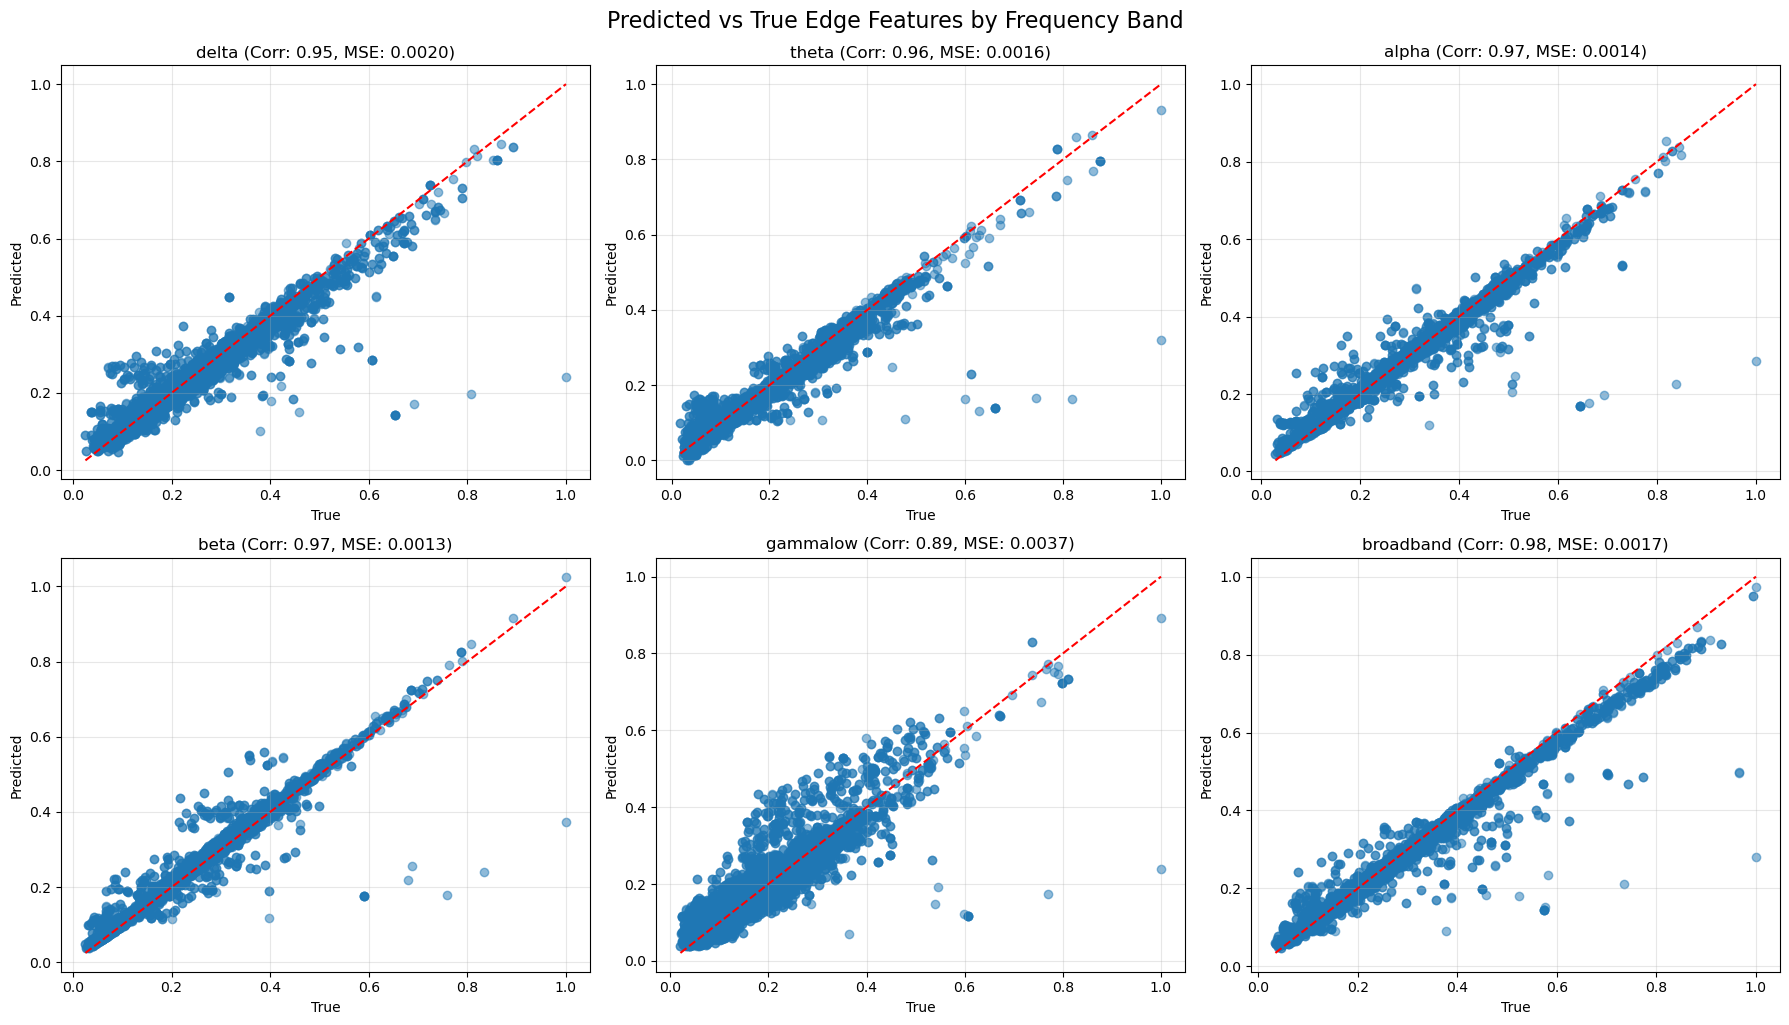


Number of points per frequency band:
delta: 4873 points
theta: 4873 points
alpha: 4873 points
beta: 4873 points
gammalow: 4873 points
broadband: 4873 points


In [49]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true values
all_preds = []
all_trues = []

# Initialize variables to calculate total MSE and MAE
test_mse = 0
test_mae = 0
total_edges = 0

# Use no_grad to ensure gradients are not calculated
with torch.no_grad():
    for graph in test_loader:
        graph = graph.to(device)  # Move graph to the correct device (GPU/CPU)
        
        # Get predictions from the model
        pred = model(graph.x, graph.edge_index, graph.edge_attr)
        
        # Ensure there are masked edges to evaluate
        if len(graph.mask_indices) > 0:
            # Get predictions and true values for the masked edges
            pred_values = pred[graph.mask_indices]
            true_values = graph.edge_attr_target[graph.mask_indices]
            
            # Store predictions and true values
            all_preds.append(pred_values.cpu())  # Move to CPU for plotting
            all_trues.append(true_values.cpu())  # Move to CPU for plotting
            
            # Calculate the MSE and MAE for this batch of data
            test_mse += F.mse_loss(pred_values, true_values, reduction='sum').item()
            test_mae += F.l1_loss(pred_values, true_values, reduction='sum').item()
            
            # Count the number of edges in the current graph
            total_edges += len(graph.mask_indices)

# Calculate average MSE and MAE
avg_mse = test_mse / total_edges
avg_mae = test_mae / total_edges

# Print the test results
print(f"\nTest Results:\nMSE: {avg_mse:.6f}\nMAE: {avg_mae:.6f}")

# Convert lists to numpy arrays for plotting
all_preds = torch.cat(all_preds, dim=0).numpy() if isinstance(all_preds, list) else all_preds
all_trues = torch.cat(all_trues, dim=0).numpy() if isinstance(all_trues, list) else all_trues

# Frequency bands to plot (make sure these match your data)
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gammalow', 'broadband']

# Plotting Predicted vs True Edge Features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, band in enumerate(frequency_bands):
    ax = axes[i]
    
    # Get the predicted and true values for this frequency band
    preds = all_preds[:, i]
    trues = all_trues[:, i]
    
    # Scatter plot of true vs predicted values
    ax.scatter(trues, preds, alpha=0.5)
    
    # Add the ideal line (perfect prediction) for reference
    ax.plot([trues.min(), trues.max()], [trues.min(), trues.max()], 'r--')  # Ideal line
    
    # Calculate correlation coefficient and MSE for this frequency band
    corr = np.corrcoef(trues, preds)[0, 1]
    mse = np.mean((preds - trues) ** 2)
    
    # Set plot title and labels
    ax.set_title(f"{band} (Corr: {corr:.2f}, MSE: {mse:.4f})")
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.grid(True, alpha=0.3)

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Predicted vs True Edge Features by Frequency Band", fontsize=16, y=1.02)

# Show the plot
plt.show()

# Print the number of points for each frequency band
print("\nNumber of points per frequency band:")

for i, band in enumerate(frequency_bands):
    preds = all_preds[:, i]
    trues = all_trues[:, i]
    count = len(preds)  # Same as len(trues)
    print(f"{band}: {count} points")


/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_1412/2796706695.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 0.97])


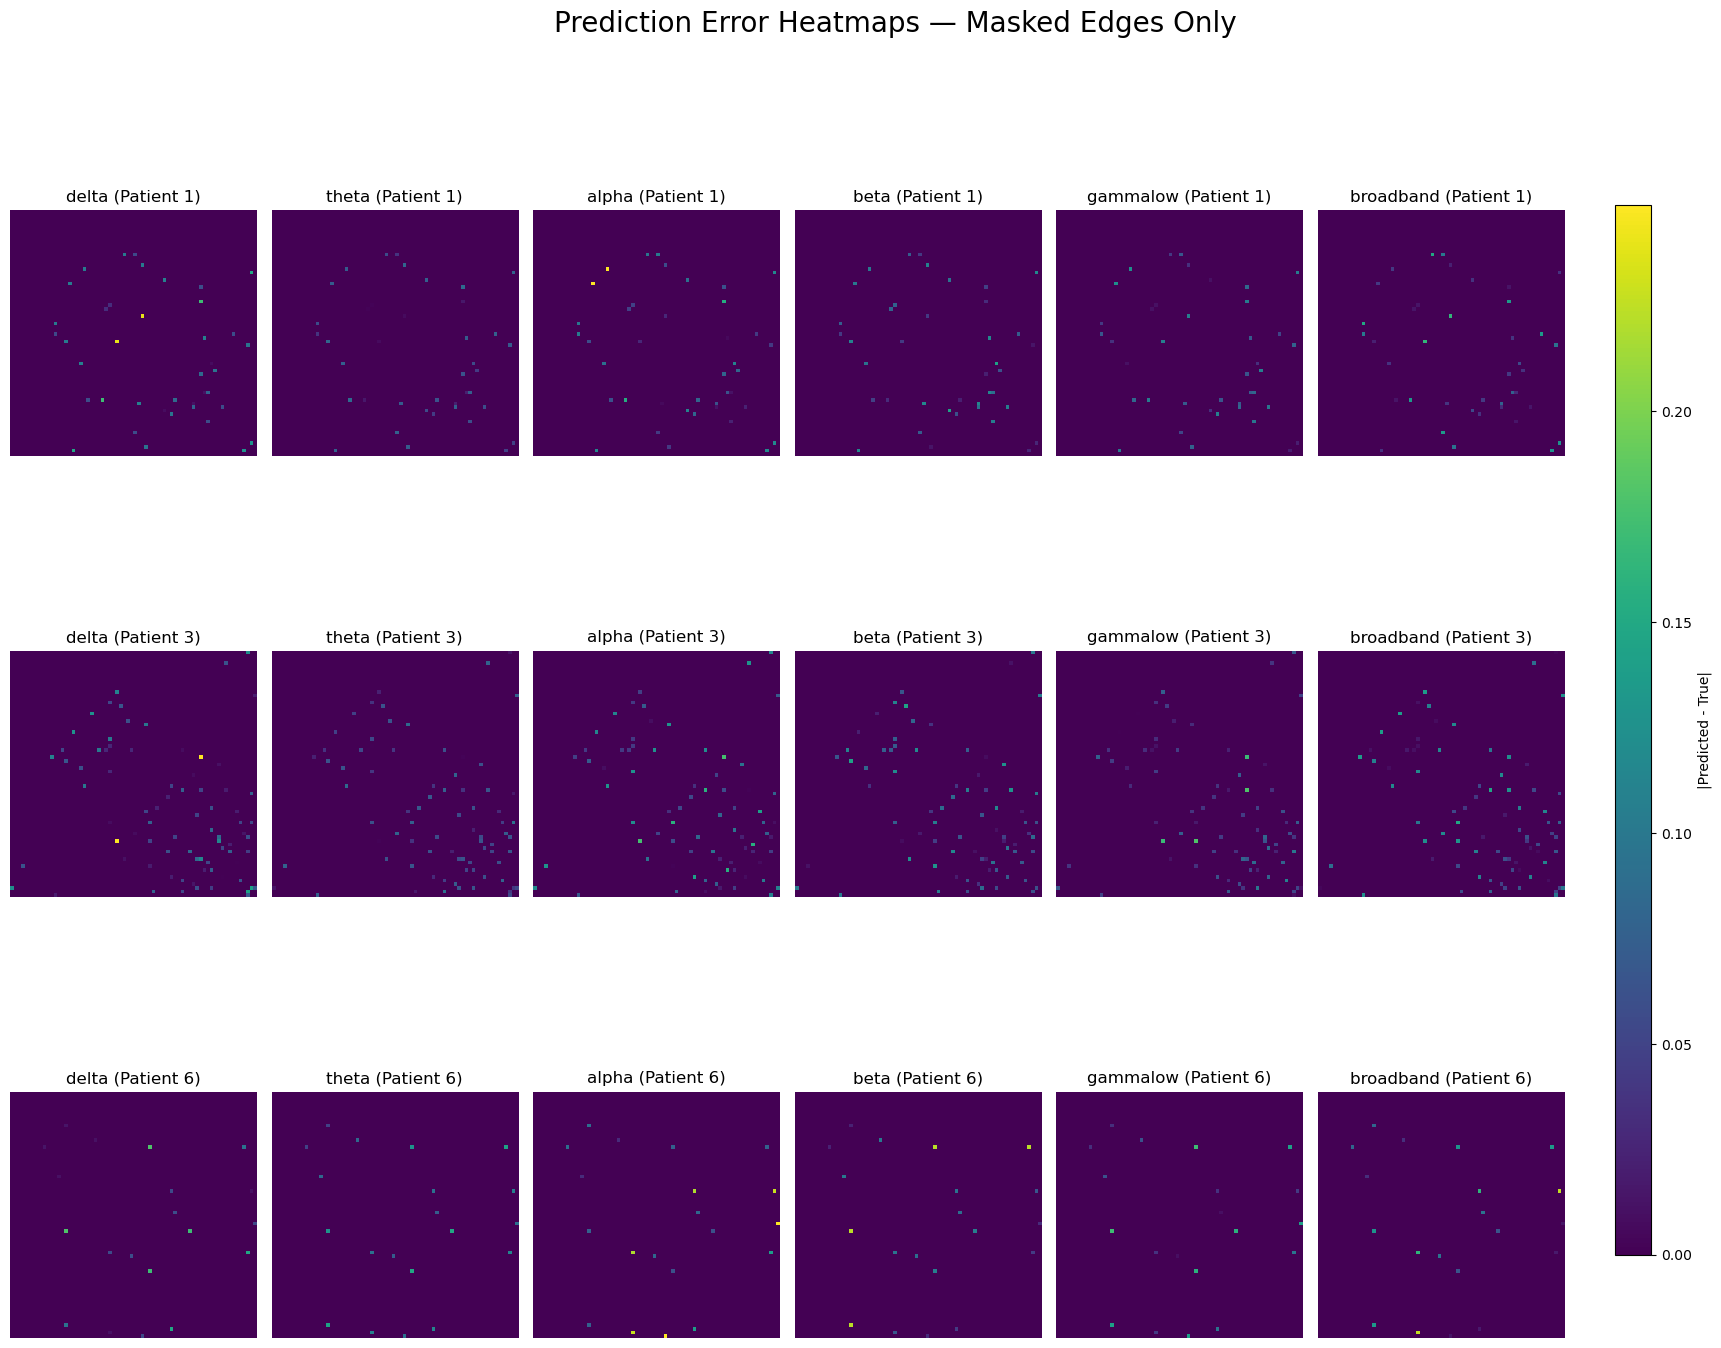

In [47]:
import matplotlib.pyplot as plt
import numpy as np

#  Choose patient indices from the test_loader dataset (batch size = 1)
patient_idxs = [1, 3, 6]  # Select graph indices from your test_loader/test_data
test_graphs = [test_loader.dataset[i] for i in patient_idxs]  # assuming test_loader.dataset is accessible

fig, axs = plt.subplots(len(patient_idxs), len(frequency_bands), figsize=(18, 5 * len(patient_idxs)))
axs = np.array(axs).reshape(len(patient_idxs), len(frequency_bands))

img_handles = []

# Loop through each selected test patient
for row_idx, graph in enumerate(test_graphs):
    graph = graph.to(device)

    with torch.no_grad():
        pred = model(graph.x, graph.edge_index, graph.edge_attr)

    num_nodes = graph.num_nodes
    num_bands = len(frequency_bands)
    edge_list = graph.edge_index.cpu().numpy().T
    masked_idx = graph.mask_indices.cpu().numpy()

    # Create error matrices (one per frequency band)
    error_matrices = [np.zeros((num_nodes, num_nodes)) for _ in range(num_bands)]

    for idx in masked_idx:
        i, j = edge_list[idx]
        pred_vec = pred[idx].cpu().numpy()
        true_vec = graph.edge_attr_target[idx].cpu().numpy()
        abs_error = np.abs(pred_vec - true_vec)

        for band in range(num_bands):
            error_matrices[band][i, j] = abs_error[band]
            error_matrices[band][j, i] = abs_error[band]

    # Plot error matrices for all frequency bands for this patient
    for band_idx, band in enumerate(frequency_bands):
        ax = axs[row_idx, band_idx]
        im = ax.imshow(error_matrices[band_idx], cmap='viridis', vmin=0, vmax=np.max(error_matrices))
        ax.set_title(f"{band} (Patient {patient_idxs[row_idx]})")
        ax.axis('off')
        img_handles.append(im)

# Adjust layout
fig.subplots_adjust(right=0.88, hspace=0.5)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(img_handles[0], cax=cbar_ax, label='|Predicted - True|')

plt.suptitle("Prediction Error Heatmaps — Masked Edges Only", fontsize=20)
plt.tight_layout(rect=[0, 0, 0.88, 0.97])
plt.show()
